# Unsupervised Learning

## Introduction

*Unsupervised learning* refers to machine learning techniques where we do not give the learning algorithm a target output (e.g. a set of expected classifications of the data). Instead, the algorithm must interpret the data entirely on its own, without any supervision from the user. Unsupervised learning is useful when we don't have access to pre-labelled data (e.g. this set of measurements corresponds to a faulty unit, while this other set of measurements corresponds to a funcitoning unit), or when we're more interested in exploring what trends exist in data (including those we may not necessarily know about).

Applications of unsupervised learning in the context of systems administration include:
* Detection of abnormal events in logs
* Automated detection of anomalous events from time series data
 * e.g. a spike in write latency on a NetApp that might indicate an errant job
* Learned models of a system of many variables which can then be used for prediction
 * e.g. a learned model of PUE from load, outside air temperature etc. that can then be used to investigate the effect of changing one of the variables
 
See [Further Reading](#Further-Reading) for more on these examples.

## Anomaly Detection

For this workshop, we'll be focusing on a simple example of time series anomaly detection.

This example is based on Chapter 4, *More Complex, Adaptive Models* from [Practical Machine Learning](https://www.safaribooksonline.com/library/view/practical-machine-learning/9781491914151/ch04.html).

### Simple Anomaly Detection

In some cases, we may be able to detect such novel patterns by merely looking for any values beyond a certain threshold:

<img src="images/simple_anomaly.jpg" style="max-width: 45%" />

In other cases, though, the structure of the waveform may prevent detection of anomalies using this method:

And more subtle errors - a change in the shape of a periodic waveform, for examples - will be simply impossible to pick up with such a method:

<img src="images/harder_anomaly.jpg" style="max-width: 45%" />

What we want more generally is a method that can learn what constitutes a "normal" waveform not just in terms of its instantaneous value in terms of its *shape*.

<img src="images/really_hard_anomaly.jpg" style="max-width: 45%" />

Our approach will be to define an "anomaly" as being some pattern in the waveform that we haven't seen before. Our algorithm will build up a library of "normal" waveform shapes, and use that library to try and reconstruct a waveform to be tested. If the reconstruction is poor, then the waveform is likely to contain something abnormal, and is therefore anomalous.

### Clustering

Let us take a step back from our problem and have a look at a simple example to demonstrate how we might go about determining what counts as "normal".

Suppose we are manufacturing power supplies. Our power supplies use capacitors from two different manufacturers. During the QA phase, for each  power supply sample we measure two variables: power efficiency and voltage ripple. We could plot a graph of one variable against another to get a sense of the distribution of the data:

<img src="images/clusters.jpg" style="max-width: 45%" />

These two variables have acceptance tolerances, as shown by the box on the graph. Within these limits, however, we find that the data tends to form two groups, or *clusters*, depending on which type of capacitor is used.

Suppose the next power supply that comes off the assembly line meets the tolerance requirements (falls within the box), but falls a way outside either of the two groups:

<img src="images/clusters_anomaly.jpg" style="max-width: 45%" />

This is a sign that there might be something wrong with the unit - that it is in some way anomalous.

Here our clusters were defined in the two-dimensional space defined by two variables (or two *features*, in machine learning parlance). But we can easily visualise how the approach can generalisable to three-dimensional space, defined by three features - or even an *n*-dimensional space, defined by *n* features. (The general case is a little harder to visualise - so just imagine a three-dimensional space and pretend there are more dimensions.)

Clusters can be identified programatically using a *clustering* algorithm. The particular method we'll be using is called *k-means clustering*.

### Waveform Space

The first step in applying such a technique to waveforms would be defining the space in which clusters will be formed. The first step will be to split the waveform into chunks to give us separate "samples". But what will our *features* be - what are the variables that will define the *n*-dimensional space?

We could go with standard measurements of each chunk such as maximum, minimum and spread. But since our technique is generalisable to any number of dimensions, we can do something a bit more clever: we can take each element of the chunk as a separate dimension. For a chunk containing 32 time values, we define a 32-dimensional space. It is in this 32-dimensional space that we will form our clusters of waveform chunks.

### Waveform Anomaly Detection

In the example of the power supplies, we detected anomalous samples based on the distance from clusters. For our waveforms, we're going to take a slightly different approach so that we can visualise what's going on.

Consider our 32-dimensional waveform space. Each point in this space represents a possible waveform chunk. Similar chunks will cluster together. The middle of each cluster (the *centroid*) will provide some measure of the prototypical waveform pattern that all those chunks are specific instances of. (If this is difficult to visualise, the other way to consider it is that the centroid is simply the mean of all waveform samples in that cluster.)

Note that the centroid, being a point in the waveform space, is itself a waveform. Thus, the cluster centroids provide us with a set of "normal" waveform chunks.

Suppose we then try to reconstruct a novel set of data using our standard "normal" chunks. If the data is similar in shape to what has come before it, we will be able to manage to good reconstruction. However, if the data contains some abnormal shape, we will not be able to reconstruct it using our normal shape library, and we will get a reconstruction error. This error will indicate an anomaly!

In summary, our algorithm will be:

**Training**:

* Split waveform data into chunks of *n* samples
* Form a space in *n* dimensions, with each chunk representing one point
* Cluster the chunk points, and determine the centres or *centroids* of the clusters
* Cluster centroids provide library of "normal" waveform shapes

**Testing**:

* Try to reconstruct waveform data to be tested using cluster centroids learned during training
* Poor reconstruction error on any individual chunk indicates anomalous shape

## Our Data Set

To explore anomaly detection, we'll be using an EKG data set from [PhysioNet](http://physionet.org/physiobank/database/apnea-ecg/) - which is essentially the squishy version of the data we'll be getting from servers. Since this data has a very regular waveform, it provides a good vehicle for us to explore the algorithms without getting bogged down in the complications that come with real-world data.

The data is supplied in the `a02.dat` file. A Python module `ekg_data.py` is provided to read the data.

## Exploring the Data

Let's get started by importing the EKG data module and examining what the data looks like:

In [58]:
from __future__ import print_function
import ekg_data

ekg_filename = 'a02.dat'
ekg_data = ekg_data.read_ekg_data(ekg_filename)
print(ekg_data.shape)

(3182000,)


The data is provided as a one-dimensional list (or *vector*) of floating-point samples:

In [59]:
print("ekg_data[0]:\t", ekg_data[0])
print("ekg_data[1]:\t", ekg_data[1])
print("ekg_data.min:\t", ekg_data.min())
print("ekg_data.max:\t", ekg_data.max())

ekg_data[0]:	 -4.0
ekg_data[1]:	 -4.0
ekg_data.min:	 -572.0
ekg_data.max:	 580.0


TODO: box plot or something

We can also plot a number of samples from the data to get a feel for the waveform:

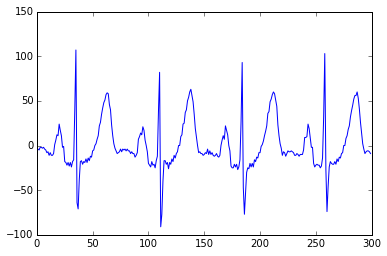

In [60]:
# IPython 'magic' command to set the matplotlib backend to display
# in the notebook
%matplotlib inline

import matplotlib.pyplot as plt

n_samples_to_plot = 300
plt.plot(ekg_data[0:n_samples_to_plot])
plt.show()
# TODO: add axis labels

Since we have rather a lot of data, we'll take just the first 8,000 samples so our examples will run a bit faster:

In [61]:
ekg_data = ekg_data[0:8192]

## Windowing

The first step in our process is to split the waveform into overlapping segments (TODO: rename code), with the sampled section of the original data sliding along by two samples each time. We take this approach so that we get instances of each waveform shape at a variety of horizontal translations.

In [86]:
import numpy as np

chunk_len = 32
slide_len = 2

chunks = []
for start_pos in range(0, len(ekg_data), slide_len):
    end_pos = start_pos + chunk_len
    # make a copy so changes to 'chunks' doesn't modify the original ekg_data
    chunk = np.copy(ekg_data[start_pos:end_pos])
    # if we're at the end and we've got a truncated chunk, drop it
    if len(chunk) != chunk_len:
        continue
    chunks.append(chunk)

print("Produced %d waveform chunks" % len(chunks))
# TODO is this right?

Produced 4081 waveform chunks


(This code is saved for later reuse in `chunk_utils.sliding_chunker`.)

Let's take a look at the segments we've produced:

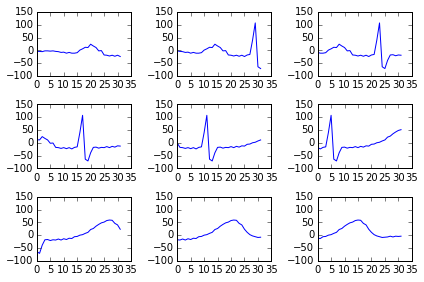

In [87]:
import chunk_utils

chunk_utils.plot_chunks(chunks, chunk_n_step=3)

Note that these chunks do not necessarily begin and end with a value of zero. This could be a problem later on: since the learned "normal" chunks will then also have non-zero starts and end, when we try to reconstruct our waveform to be tested by adding together our learned chunks, we'll end up with discontinuities.

The way we avoid this problem is to apply a *window function* to the data, which forces the start and end to be zero. A simple window function we can apply is the first half of a sine wave:

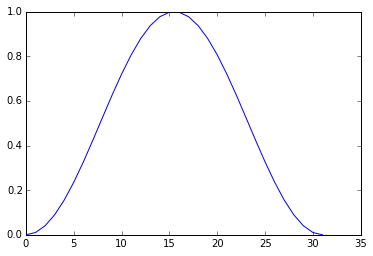

In [88]:
window_rads = np.linspace(0, np.pi, chunk_len)
window = np.sin(window_rads)**2
plt.plot(window)

We then multiply each chunk in turn by this window function:

In [89]:
windowed_chunks = []
for chunk in chunks:
    windowed_chunk = np.copy(chunk) * window
    windowed_chunks.append(windowed_chunk)

Plotting the result, we see the difference the windowing process makes. The chunks are now flat at the start and end - perfect to be joined together later.

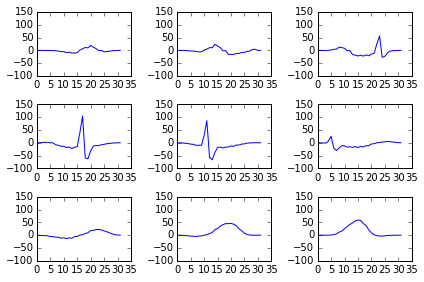

In [91]:
chunk_utils.plot_chunks(windowed_chunks, chunk_n_step=3)

Note that windowing also has the effect of making the chunks less affected by the waveform either side of the chunk: the waveform shape represented by the chunk is now more "concentrated" in the middle.

## Clustering

In [66]:
from sklearn.cluster import KMeans

clusterer = KMeans(n_clusters=150)
clusterer.fit(windowed_chunks)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=150, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

## Reconstruction from Clusters

In [76]:
slide_len = chunk_len/2
test_chunks = chunk_utils.sliding_chunker(
    ekg_data,
    window_len=chunk_len,
    slide_len=slide_len
)

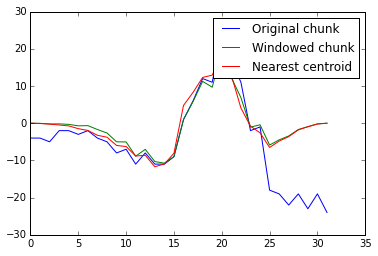

In [80]:
centroids = clusterer.cluster_centers_

chunk = np.copy(test_chunks[0])
# remember, the clustering was set up using the windowed data
# so to find 
windowed_chunk = chunk * window
# TODO: what's array about?
nearest_centroid_idx = clusterer.predict(windowed_chunk)[0]
nearest_centroid = np.copy(centroids[nearest_centroid_idx])
plt.figure()
plt.plot(chunk, label="Original chunk")
plt.plot(windowed_chunk, label="Windowed chunk")
plt.plot(nearest_centroid, label="Nearest centroid")
plt.legend()
# TODO: are the shows necessary?
plt.show()

Try changing the chunk index to see the reconstruction for different chunks.

Maximum reconstruction error was 8.8
98th percentile of reconstruction error was 5.7


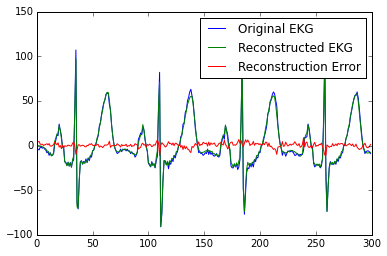

In [83]:
reconstruction = np.zeros(len(ekg_data))
slide_len = chunk_len/2

for chunk_n, chunk in enumerate(test_chunks):
    # don't modify the data in chunks
    chunk = np.copy(chunk)
    chunk *= window
    nearest_centroid_idx = clusterer.predict(chunk)[0]
    centroids = clusterer.cluster_centers_
    nearest_centroid = np.copy(centroids[nearest_centroid_idx])
    
    pos = chunk_n * slide_len
    reconstruction[pos:pos+chunk_len] += nearest_centroid

n_plot_samples = 300

error = reconstruction[0:n_plot_samples] - ekg_data[0:n_plot_samples]
error_98th_percentile = np.percentile(error, 98)
print("Maximum reconstruction error was %.1f" % error.max())
print("98th percentile of reconstruction error was %.1f" % error_98th_percentile)

plt.plot(ekg_data[0:n_plot_samples], label="Original EKG")
plt.plot(reconstruction[0:n_plot_samples], label="Reconstructed EKG")
plt.plot(error[0:n_plot_samples], label="Reconstruction Error")
plt.legend()
plt.show()

This reconstruction code is also in `learn_utils.reconstruct`.

## Anomaly Detection

To see the effect that an anomalous value has on the reconstruction error, try manually inserting an anomaly - for example, zeroing out a small number of samples:

In [84]:
ekg_data_anomalous = np.copy(ekg_data)
ekg_data_anomalous[210:215] = 0

We'll then try to reconstruct this data using the same code as above:

Maximum reconstruction error was 55.6
98th percentile of reconstruction error was 6.8


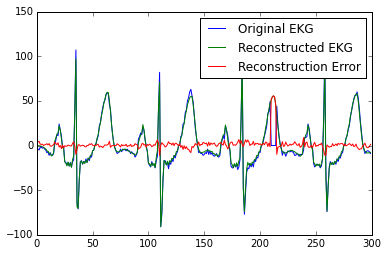

In [85]:
import learn_utils

recontruction = \
    learn_utils.reconstruct(ekg_data_anomalous, window, clusterer)
    
error = reconstruction[0:n_plot_samples] - ekg_data_anomalous[0:n_plot_samples]
error_98th_percentile = np.percentile(error, 98)
print("Maximum reconstruction error was %.1f" % error.max())
print("98th percentile of reconstruction error was %.1f" % error_98th_percentile)

plt.plot(ekg_data_anomalous[0:n_plot_samples], label="Original EKG")
plt.plot(reconstruction[0:n_plot_samples], label="Reconstructed EKG")
plt.plot(error[0:n_plot_samples], label="Reconstruction Error")
plt.legend()
plt.show()

The anomaly has produced a shape in the waveform that hadn't been seen before, and therefore it couldn't be reconstructed using the learned shape library. This gave a large reconstruction error, which could easily be detected by a simple threshold monitor.

## Conclusion

We've looked at one specific example of the use of unsupervised learning techniques in systems administration: anomaly detection of time series data based on reconstruction error from k-means clustering.

This problem could have been solved in different ways. For example, we could have trained a predictive neural network model, and examine the difference between the predicted waveform and the actual waveform.

In general, there is no 'one size fits all' solution in machine learning - different algorithms will be required for different problems.

## Further Reading

* See [Cluster - K-means algorithm](https://class.coursera.org/ml-003/lecture/78) on Coursera for more information on how the k-means algorithm works
* Google's [http://googleblog.blogspot.co.uk/2014/05/better-data-centers-through-machine.html](Better data centers through machine learning) shows a use of neural networks to build a predictive model of data center PUE